In [1]:
from SimPEG import Mesh
from simpegem1d import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Make it bit more efficient: Do not compute all 811 frequency components, but 

In [13]:
TDsurvey = BaseEM1D.EM1DSurveyTD()
TDsurvey.rxLoc = np.array([0., 0., 100.+30.])
TDsurvey.srcLoc = np.array([0., 0., 100.+80.])
TDsurvey.fieldtype = 'secondary'
TDsurvey.waveType = 'stepoff'
TDsurvey.srcType = 'VMD'
TDsurvey.offset = 1e-5
print TDsurvey.offset
cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(10)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]
TDsurvey.depth = depth
TDsurvey.topo = topo
TDsurvey.LocSigZ = LocSigZ
TDsurvey.time = np.logspace(-5, -2.5, 64)
TDsurvey.setFrequency(TDsurvey.time)
TDsurvey.Setup1Dsystem()
sig_half = 1e-3
sig_blk = 1e-2
chi_half = 0.
Expmap = BaseEM1D.BaseEM1DMap(mesh1D)

1e-05


In [14]:
sig  = np.ones(nlay)*sig_half
blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
sig[blk_ind] = sig_blk

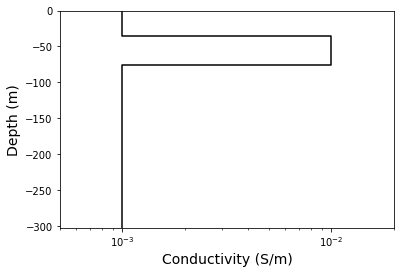

In [15]:
Utils1D.plotLayer(sig, LocSigZ)

In [16]:
WT0, WT1, YBASE = DigFilter.LoadWeights()
options = {'WT0': WT0, 'WT1': WT1, 'YBASE': YBASE}
prob = EM1D.EM1D(mesh1D, sigmaMap = Expmap, **options)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.CondType = 'Real'
prob.chi = np.zeros(TDsurvey.nlay)

In [17]:
TDsurvey.rxType = 'Bz'

In [18]:
%%time
m_test = np.log(sig)
d_test1 = TDsurvey.dpred(m_test)

CPU times: user 9.06 s, sys: 51.4 ms, total: 9.11 s
Wall time: 9.25 s


In [19]:
%%time
TDsurvey.switchInterp = True
TDsurvey.setFrequency(TDsurvey.time)
d_test2 = TDsurvey.dpred(m_test)

CPU times: user 976 ms, sys: 13.3 ms, total: 989 ms
Wall time: 1.08 s


In [20]:
TDsurvey.rxType = 'dBzdt'

In [21]:
%%time
TDsurvey.switchInterp = False
TDsurvey.setFrequency(TDsurvey.time)
m_test = np.log(sig)
dt_test1 = TDsurvey.dpred(m_test)

CPU times: user 10.2 s, sys: 97 ms, total: 10.3 s
Wall time: 11.3 s


In [22]:
%%time
TDsurvey.switchInterp = True
TDsurvey.setFrequency(TDsurvey.time)
dt_test2 = TDsurvey.dpred(m_test)

CPU times: user 1.08 s, sys: 14.5 ms, total: 1.1 s
Wall time: 1.15 s


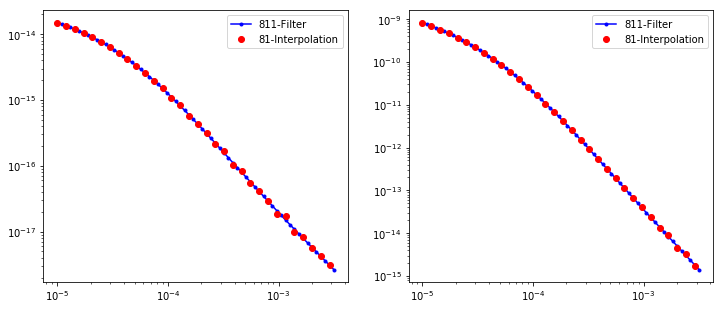

In [23]:
fig, axes = subplots(1,2, figsize = (12,5))
axes[0].plot(TDsurvey.time, d_test1, 'b.-')
axes[0].plot(TDsurvey.time[::2], d_test2[::2], 'ro')
axes[0].set_xscale('log');
axes[0].set_yscale('log');
axes[1].plot(TDsurvey.time, -dt_test1, 'b.-')
axes[1].plot(TDsurvey.time[::2], -dt_test2[::2], 'ro')
axes[1].set_xscale('log');
axes[1].set_yscale('log');
axes[0].legend(('811-Filter', '81-Interpolation'))
axes[1].legend(('811-Filter', '81-Interpolation'))

## Discussion
### a. Compute frequency in logarthmic scale (81, from 1e-3 - 1e8 Hz), then interpolate back to filter frequencies
### b. Put zero values for other filter frequencies beyond this range
### c. Works well $\sigma_{half}$ = $10^{-4}$ - $10^{2}$  S/m
### d. A lot more efficient. Ten times faster than before. So inversion migth be durable
### e. I can do same thing for spatial frequency, but not sure I need to do 